# Applications of ECOSTRESS: Drought and Wildfire Risk Assessment
## 📍Rocky Mountain National Park, Colorado, USA

STILL IN DRAFT

#### Land Acknowledgement Statement

#### Introduction

Wildfire impacts to communities are on the rise across much of the world and especially in western North America. Increasing extreme fire behavior and societal impacts are associated with a warmer and drier climate (REF), lack of fire and a culture of fire suppression in fire-prone regions (REF), and rapid development in flammable landscapes (REF). 

The Wildland Urban Interface (WUI), where homes and building intermix with wildland fuels, is the fastest growing land use type in the US with XXXM more people living in the WUI since XXXX leading to increasing wildfire-related impacts (REF). While many regions of the western US are at high risk, the Colorado Front Range is particularly vulnerable/susceptible given the rapidly growing population and impacts from changing climatic patterns leading to more extreme fire behavior (REF). 

The 2020 fire season was record-setting in terms of area burned globally (REF). In CO it produced three of the state's top five largest wildfires. In particular, the Cameron Peak and East Troublesome fires both resulted in extreme fire behavior and hundreds of destroyed structures on the Front Range.

Satellite earth observation (EO) has contributed to major advances in understanding fire risk and impacts in recent decades. Characterization of vegetative fuel using multispectral and radar imagery has changed the way we model fire behavior. Active mapping of wildfire hotspots and daily growth has improved firefighter safety and led to a better understanding of the mechanisims which drive fire growth. Future advances in tracking fuel conditions in near-real-time will improve our ability to understand and map fire risk for communities and fire management personnel.

The ECOSTRESS mission provides thermal remote sensing and derivatives such as evapotranspiration. These metrics provide crucial information on the conditions of vegetation fuels on the landscape. Previous research has shown relationships between the intensity and severity of a wildfire and the water stress in plants measured in the months before wildfire: https://ecostress.jpl.nasa.gov/news/111cnasa-data-on-plant-2018sweating-could-help-predict-wildfire-severity

In this case study, we will use ECOSTRESS data on Land Surface Temperature (LST) and derived Evaporative Stress Index (ESI) to assess wildfire risk in a populated area leading up to the extreme 2020 wildfires. Our focus will be on the areas around Rocky Mountain National Park (RMNP) which include the towns of Estes Park and Grand Lake, CO.

Goals for this notebook:

- Search for ECOSTRESS data using 'earthaccess' and a region of interest
- Use the cloud cover product to identify granules with low cloud cover
- Download the data granules for further analysis

Citations:

1.
2.

Data Sources:
- Colorado Fire Protection Districts:
- Rocky Mountain National Park boundary:

## Search and download ECOSTRESS data with 'earthaccess'

In this notebook, we will use the 'earthaccess' Python package to search and download ECOSTRESS data products which overlap the Park. For more background and detailed examples of using 'earthaccess', refer to the introductory notebook from earlier in the workshop (link to intro notebook). Using this package, we can search for ECOSTRESS granules using our region of interest and identify ones which meet certain criteria for analysis.

### Step 1. Setup the Notebook

First, we need to import our Python packages and define some environment variable like coordinate reference systems and file paths. 

In [1]:
"""
Load the necessary packages and set environment variables
"""

# Import packages
import os, shutil, time
import datetime
import folium
import earthaccess
import warnings
import folium.plugins
import pandas as pd
import geopandas as gpd
import rasterio as rio
import rioxarray as rxr
import math

from osgeo import gdal
from branca.element import Figure
from IPython.display import display
from shapely import geometry
from skimage import io
from datetime import timedelta
from shapely.geometry.polygon import orient
from matplotlib import pyplot as plt

# Projection information
geog = 'EPSG:4326'  # Geographic projection
prj = 'EPSG:5070'  # Projected coordinate system- WGS 84 NAD83 UTM Zone 13N

# File path information
datadir = '/data-store/iplant/home/shared/esiil/HYR_SENSE/'

# File path information
print("Success")

Success


#### Define Custom Functions

These helper functions will be used throughout the notebook. For each function, there is a description of what purpose it serves and where it is used in the notebook. Feel free to read through each function to get an idea of what it does, but we will not cover these in great detail. Ask a facilitator if you have any questions!

In [2]:
def get_shapely_object(result:earthaccess.results.DataGranule):
    """
    Retrieve geospatial information from ECOSTRESS granule footprints.
    This function allows us to retrieve the geographic coverage for each granule and plot it on a map.
    
    :param 'result:earthaccess.results.DataGranule': a single data granule from earthaccess data search
    """
    
    # Get Geometry Keys
    geo = result['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']
    keys = geo.keys()

    if 'BoundingRectangles' in keys:
        bounding_rectangle = geo['BoundingRectangles'][0]
        # Create bbox tuple
        bbox_coords = (bounding_rectangle['WestBoundingCoordinate'],bounding_rectangle['SouthBoundingCoordinate'],
                       bounding_rectangle['EastBoundingCoordinate'],bounding_rectangle['NorthBoundingCoordinate'])
        # Create shapely geometry from bbox
        shape = geometry.box(*bbox_coords, ccw=True)
    elif 'GPolygons' in keys:
        points = geo['GPolygons'][0]['Boundary']['Points']
        # Create shapely geometry from polygons
        shape = geometry.Polygon([[p['Longitude'],p['Latitude']] for p in points])
    else:
         raise ValueError('Provided result does not contain bounding boxes/polygons or is incompatible.')
    return(shape)


def get_png(result:earthaccess.results.DataGranule):
    """
    Retrieve the browse image from the search results
    This browse image can be used to display the granule quickly and effectively before downloading

    :param 'result:earthaccess.results.DataGranule': a single data granule from earthaccess data search
    """
    https_links = [link for link in result.dataviz_links() if 'https' in link]
    if len(https_links) == 1:
        browse = https_links[0]
    elif len(https_links) == 0:
        browse = 'no browse image'
        warnings.warn(f"There is no browse imagery for {result['umm']['GranuleUR']}.")
    else:
        browse = [png for png in https_links if '.png' in png][0]
    return(browse)


def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation
    Leaflet interactive maps require a specific format for coordinates, this function sets that up for a given bounding box.

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))


def extract_granule_id(link):
    return os.path.basename(link)[:-3]
    
print("Functions are ready to use!")

Functions are ready to use!


### Step 2. Data Preparation

#### Accessing data from the CyVerse Data Store

The CyVerse "data store" contains some geospatial and tabular data for the workshop. These data can be accessed directly using file paths. However, this sometimes can cause delays. To avoid these issues, we can copy the data for this notebook into a local directory.

In [3]:
"""
Copy the data-store to 'local' directory
This enables quick access to data files
"""

# Identify the location of the HYR-SENSE "data store"
data_store_path = '/data-store/iplant/home/shared/esiil/HYR_SENSE/data/Drought-FireRisk'
# Set a destination path (this is a 'local' and temporary path)
dest = '/home/jovyan/HYR-SENSE/data/Drought-FireRisk/' # in the GitHub repo we cloned
if not os.path.exists(dest):
    os.mkdir(dest) # create the directory for the copied data, if needed
    
# Using 'shutil' package, copy all the files over
shutil.copytree(data_store_path, dest, dirs_exist_ok=True)

'/home/jovyan/HYR-SENSE/data/Drought-FireRisk/'

#### Importing project data

Now that we have a local copy of our project data, we can read in some of the data files like our region of interest (ROI). For this notebook, we will load two spatial datasets:

- Rocky Mountain National Park (RMNP)
- Colorado Fire Protection Districts (FPDs)

Fire protection districts (FPDs) are ...

To begin, let's create a map of our ROI and the intersecting FPDs.

NOTE: add town labels (?) or make this an interactive map. Add fire boundaries (Cameron Peak and East troublesome)

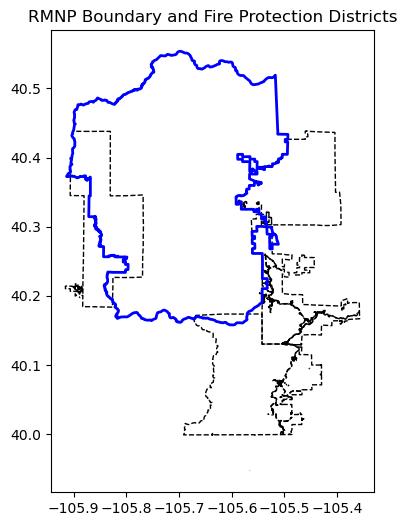

In [4]:
# Load the RMNP boundary as a GeoJSON using the Python package GeoPandas
rmnp = gpd.read_file(os.path.join(dest, 'NPS_ROMO_Boundary.geojson'))
rmnp = rmnp.to_crs(prj) # projected CRS

# Load the Colorado Fire Protection Districts
# Intersect with the RMNP boundary
fpd = gpd.read_file(os.path.join(dest, 'CO_Fire_Protection_Districts.geojson'))
fpd = fpd.to_crs(prj) # make sure the projections match
fpd_rmnp = fpd[fpd.intersects(rmnp.unary_union)] # Perform the spatial intersection

# Create a map of RMNP and adjacent FPDs
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# Plot the intersecting Fire Protection Districts
# (convert to geographic coordinates so axis labels are in lat/long)
fpd_rmnp.to_crs(geog).plot(ax=ax, color='none', edgecolor='black', linewidth=1, linestyle='--', label='Intersecting Districts')
# Plot the RMNP boundary 
rmnp.to_crs(geog).plot(ax=ax, color='none', edgecolor='blue', linewidth=2, label='RMNP Boundary')
# Add legend and title

plt.title('RMNP Boundary and Fire Protection Districts')
plt.show()

### Step 3. Search for ECOSTRESS Data 
 - Land Surface Temperature and Emissivity Daily L2 Global 70 m
 - Evaporative Stress Index (ESI) PT-JPL Daily L4 Gloabl 70 m 

Now that we have our ROI loaded, we can use the 'earthaccess' Python package to find ECOSTRESS data products. In particular, we will search for the Land Surface Temperature and Emissivity Daily Gridded L2 70-m and the Evaporative Stress Index Daily L4 70 m products. With earthaccess, we can search for and print all of the available data sets. Using this capability, we can also search for a specific data product by its "short name". To start, let's get a list of all the ECOSTRESS products available.

Read more about the data products:\
ECOSTRESS LSTE: https://lpdaac.usgs.gov/products/eco2lstev001/ \
ECOSTRESS ESI: https://lpdaac.usgs.gov/products/eco4esiptjplv001/


In [5]:
# Log in to your NASA Earthdata
# You only have to do this once in your session (persist=True saves the credentials)
auth = earthaccess.login(persist=True)

#### Search for available ECOSTRESS products

To begin, we can identify a list of available products. The "ShortName" attribute may not give enough description, so some initial work to identify which data products you are interested in is helpful. There are currently two data versions available.

In our case we are looking for LST and ESI. Because we are searching for data for the 2020 wildfire season, we may not have any Version 002 data available. 

In [6]:
## Query the collections for ECOSTRESS
Query = earthaccess.collection_query().keyword('ECOSTRESS')
print(f'Collections found: {Query.hits()}')

# Return search results as a list
collections = Query.fields(['ShortName']).get(Query.hits())

# Retrieve Collection short-names
print("All available data products: ")
[product['short-name'] for product in [collection.summary() for collection in collections]]

Collections found: 37
All available data products: 


['ECO2LSTE',
 'ECO4ESIPTJPL',
 'ECO4WUE',
 'ECO3ETPTJPL',
 'ECO2CLD',
 'ECO1BMAPRAD',
 'ECO1BRAD',
 'ECO3ETALEXI',
 'ECO4ESIALEXI',
 'ECO1BGEO',
 'ECO4ESIALEXIU',
 'ECO_L4G_ESI',
 'ECO_L4G_WUE',
 'ECO_L4T_ESI',
 'ECO_L4T_WUE',
 'ECO3ANCQA',
 'ECO3ETALEXIU',
 'ECO_L3G_JET',
 'ECO_L3G_MET',
 'ECO_L3G_SEB',
 'ECO_L3G_SM',
 'ECO_L3T_JET',
 'ECO_L3T_MET',
 'ECO_L3T_SEB',
 'ECO_L3T_SM',
 'ECO_L2G_CLOUD',
 'ECO_L2G_LSTE',
 'ECO_L2T_LSTE',
 'ECO_L2T_STARS',
 'ECO_L2_CLOUD',
 'ECO_L2_LSTE',
 'ECO1BATT',
 'ECO_L1B_ATT',
 'ECO_L1B_GEO',
 'ECO_L1B_RAD',
 'ECO_L1CG_RAD',
 'ECO_L1CT_RAD']

#### Define a search request using 'earthaccess'

We are ready to submit a search request for our ECOSTRESS data over RMNP. We want to find data to assess the drought conditions and wildfire risk during the 2020 fire season and leading up to the start of both the East Troublesome and Cameron Peak wildfires. So, we will search for both LST and ESI from mid-June to mid-August, prior to the ignition of these fires. 

In the code chunk below, we first check to see if there are data granules from the Version 002 (V2) ECOSTRESS products. Because V2 data is being retroactively added to EarthData, the availability are limited in some regions. If no products exist, we can check for V1 data.

Add more description of the below code chunk ...

In [7]:
# 1. Define some search parameters 
# Version 001: ['ECO2LSTE', 'ECO4ESIPTJPL']
# Version 002: ['ECO_L2T_LSTE', 'ECO_L4T_ESI']
short_names =  ['ECO2LSTE', 'ECO4ESIPTJPL']
date_range = ('2020-06-15','2020-08-15') # June15-August15 2020

# 2. Retrieve the coordinate pairs for the region of interest
geom = rmnp.geometry.to_crs(geog) # convert back to geographic coordinates
geom = geom.unary_union.envelope # dissolve into a single shape and get the envelope
coords = list(geom.exterior.coords) # retrieve the coordinate pairs

# 3. Loop through each short name, create a new search
# Looping here helps us see how many tiles exist for each product
results = {} # empty dictionary to store the search results for each product
for short_name in short_names:
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f"Data product: {short_name}")
    
    # 3a. Search for ECOSTRESS products matching our short name
    result = earthaccess.search_data(
        short_name=short_name,
        polygon=coords,
        temporal=date_range,
        count=500, 
    )
        
    # 3b. Extract the search results as a data frame
    df = pd.json_normalize(result)
    df['shortname'] = short_name

    # 3c. Create shapely polygons for result (granule footprints)
    geometries = [get_shapely_object(result[index]) for index in df.index.to_list()]
    # Convert to GeoDataframe
    results_gdf = gpd.GeoDataFrame(df, geometry=geometries, crs="EPSG:4326")

    # 3d. Add browse imagery links (we will use this later)
    results_gdf['browse'] = [get_png(granule) for granule in result]
    
    # 3e. Retrieve the data links (used later for downloading)
    data_links = pd.DataFrame([granule.data_links()[0] for granule in result], columns=['data_link']) 
    results_gdf = pd.concat([results_gdf, data_links], axis=1)  # join the data links back to our search results

    # 3f. Tidy the data columns
    # Rename some of the columns for easier access
    results_gdf = results_gdf.copy()
    results_gdf.rename(
        columns = {'meta.concept-id':'concept_id',
                   'meta.native-id':'granule',
                   'umm.TemporalExtent.RangeDateTime.BeginningDateTime':'start_datetime',
                   'umm.TemporalExtent.RangeDateTime.EndingDateTime':'end_datetime',
                   'umm.DataGranule.DayNightFlag':'day_night',
                   'umm.CloudCover':'cloud_cover',
                  }, inplace=True)
    # Tidy up the date field and extract the time of day
    results_gdf['datetime_obj'] = pd.to_datetime(results_gdf['start_datetime']) 
    results_gdf['time_of_day'] = results_gdf['datetime_obj'].dt.time

    results_gdf['identifier'] = results_gdf['umm.DataGranule.Identifiers'].apply(lambda x: x[0]['Identifier'])

     # 3f. Filter for daytime observations
    results_gdf = results_gdf[results_gdf['day_night'].str.contains('Day')]
    print(f'Daytime observations: {len(results_gdf)}')
    
    # Add to the dictionary
    results[short_name] = results_gdf

~~~~~~~~~~~~~~~~~~~~~~~~~~~
Data product: ECO2LSTE
Granules found: 83
Daytime observations: 54
~~~~~~~~~~~~~~~~~~~~~~~~~~~
Data product: ECO4ESIPTJPL
Granules found: 56
Daytime observations: 54


#### Examine the metadata from the search results  
It looks like we have some options for V1 data products during this spatial and temporal window. However, to identify data granules which will be useful for analysis, we need to dig into the metadata a bit more. Thankfully, the earthaccess enables us to work with the metadata from our search results as a data frame. 

In [8]:
# Let's take a look at the columns available in the metadata
for key, value in results.items():
    print(key)
    print(f'{len(value)} granules total.')
    print(value.columns)

ECO2LSTE
54 granules total.
Index(['size', 'meta.concept-type', 'concept_id', 'meta.revision-id',
       'granule', 'meta.collection-concept-id', 'meta.provider-id',
       'meta.format', 'meta.revision-date', 'start_datetime', 'end_datetime',
       'umm.OrbitCalculatedSpatialDomains', 'umm.GranuleUR',
       'umm.AdditionalAttributes', 'umm.MeasuredParameters',
       'umm.SpatialExtent.HorizontalSpatialDomain.Geometry.BoundingRectangles',
       'umm.ProviderDates', 'umm.CollectionReference.EntryTitle',
       'umm.PGEVersionClass.PGEVersion', 'umm.RelatedUrls', 'day_night',
       'umm.DataGranule.Identifiers', 'umm.DataGranule.ProductionDateTime',
       'umm.DataGranule.ArchiveAndDistributionInformation', 'umm.Platforms',
       'umm.MetadataSpecification.URL', 'umm.MetadataSpecification.Name',
       'umm.MetadataSpecification.Version', 'shortname', 'geometry', 'browse',
       'data_link', 'datetime_obj', 'time_of_day', 'identifier'],
      dtype='object')
ECO4ESIPTJPL
54 granu

#### Keep only granules which fully contain our study region

Using the footprint spatial information, we can remove granules from our list which do not fully contain our study region.

In [9]:
# Function to check if a bounding box fully contains the romo region
def bbox_contains(bbox_geom, roi_geom):
    return bbox_geom.contains(roi_geom.unary_union)

# Filter results based on spatial containment
results_rmnp = {}
for key, gdf in results.items():
    print(f'{key}: {len(value)} granules total.')
    # Check if the granule completely contains the bounding box of our study region
    filtered = gdf[gdf['geometry'].apply(lambda x: bbox_contains(x, rmnp.geometry.to_crs(geog)))]
    print(f'Removed {len(gdf)-len(filtered)} granules with partial overlap. \n ({len(filtered)} total)')
    
    # Append the filtered results back to the new dictionary
    results_rmnp[key] = filtered

# Examine the data frame for one product
results_rmnp[short_names[0]].head()

ECO2LSTE: 54 granules total.
Removed 13 granules with partial overlap. 
 (41 total)
ECO4ESIPTJPL: 54 granules total.
Removed 13 granules with partial overlap. 
 (41 total)


,size,meta.concept-type,concept_id,meta.revision-id,granule,meta.collection-concept-id,meta.provider-id,meta.format,meta.revision-date,start_datetime,...,umm.MetadataSpecification.URL,umm.MetadataSpecification.Name,umm.MetadataSpecification.Version,shortname,geometry,browse,data_link,datetime_obj,time_of_day,identifier
3,667.132,granule,G1863850506-LPDAAC_ECS,3,SC:ECO2LSTE.001:2379537312,C1534729776-LPDAAC_ECS,LPDAAC_ECS,application/echo10+xml,2020-12-24T04:05:35.481Z,2020-06-16T15:24:57.540Z,...,https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,ECO2LSTE,"POLYGON ((-102.85983 36.60378, -102.85983 41.4...",https://e4ftl01.cr.usgs.gov//WORKING/BRWS/Brow...,https://e4ftl01.cr.usgs.gov//ECOB/ECOSTRESS/EC...,2020-06-16 15:24:57.540000+00:00,15:24:57.540000,ECOSTRESS_L2_LSTE_11036_004_20200616T152457_06...
4,667.132,granule,G1863817113-LPDAAC_ECS,3,SC:ECO2LSTE.001:2379536213,C1534729776-LPDAAC_ECS,LPDAAC_ECS,application/echo10+xml,2020-12-24T03:06:27.373Z,2020-06-16T15:25:50.500Z,...,https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,ECO2LSTE,"POLYGON ((-99.39580 38.58676, -99.39580 43.494...",https://e4ftl01.cr.usgs.gov//WORKING/BRWS/Brow...,https://e4ftl01.cr.usgs.gov//ECOB/ECOSTRESS/EC...,2020-06-16 15:25:50.500000+00:00,15:25:50.500000,ECOSTRESS_L2_LSTE_11036_005_20200616T152550_06...
5,667.132,granule,G1863871948-LPDAAC_ECS,3,SC:ECO2LSTE.001:2379540306,C1534729776-LPDAAC_ECS,LPDAAC_ECS,application/echo10+xml,2020-12-24T04:05:36.216Z,2020-06-16T21:54:45.960Z,...,https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,ECO2LSTE,"POLYGON ((-103.90718 38.09339, -103.90718 43.2...",https://e4ftl01.cr.usgs.gov//WORKING/BRWS/Brow...,https://e4ftl01.cr.usgs.gov//ECOB/ECOSTRESS/EC...,2020-06-16 21:54:45.960000+00:00,21:54:45.960000,ECOSTRESS_L2_LSTE_11040_006_20200616T215445_06...
6,667.132,granule,G1863905790-LPDAAC_ECS,3,SC:ECO2LSTE.001:2379541563,C1534729776-LPDAAC_ECS,LPDAAC_ECS,application/echo10+xml,2020-12-24T04:05:34.559Z,2020-06-16T21:55:37.930Z,...,https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,ECO2LSTE,"POLYGON ((-100.68878 36.07242, -100.68878 41.2...",https://e4ftl01.cr.usgs.gov//WORKING/BRWS/Brow...,https://e4ftl01.cr.usgs.gov//ECOB/ECOSTRESS/EC...,2020-06-16 21:55:37.930000+00:00,21:55:37.930000,ECOSTRESS_L2_LSTE_11040_007_20200616T215537_06...
8,667.132,granule,G1870641025-LPDAAC_ECS,3,SC:ECO2LSTE.001:2380060030,C1534729776-LPDAAC_ECS,LPDAAC_ECS,application/echo10+xml,2020-12-24T04:05:29.589Z,2020-06-19T14:37:59.850Z,...,https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,ECO2LSTE,"POLYGON ((-105.42860 38.38158, -105.42860 43.2...",https://e4ftl01.cr.usgs.gov//WORKING/BRWS/Brow...,https://e4ftl01.cr.usgs.gov//ECOB/ECOSTRESS/EC...,2020-06-19 14:37:59.850000+00:00,14:37:59.850000,ECOSTRESS_L2_LSTE_11082_004_20200619T143759_06...


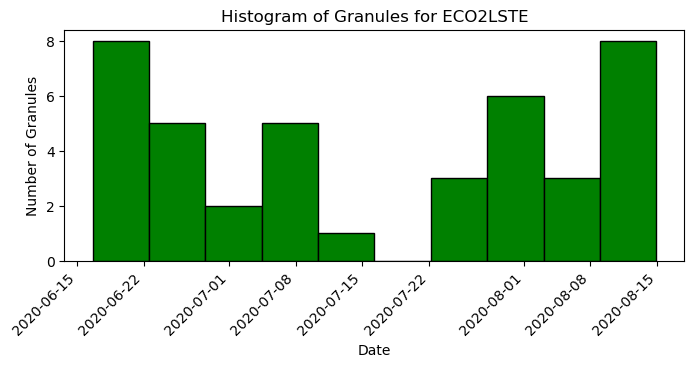

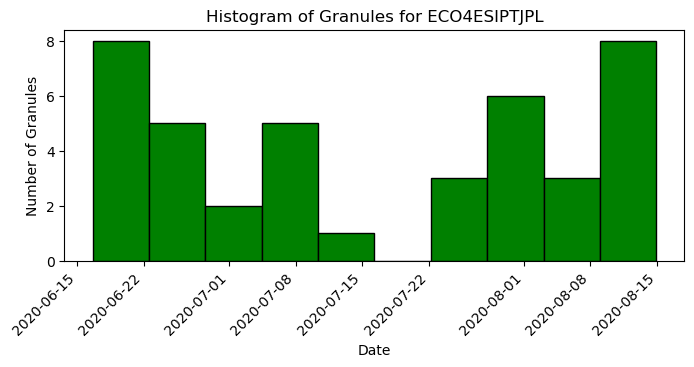

In [10]:
# Plot the histogram of granules for each time period
for key, gdf in results_rmnp.items():
    plt.figure(figsize=(8, 3))
    plt.hist(gdf['datetime_obj'], bins=10, color='green', edgecolor='black', linewidth=1)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Histogram of Granules for {key}')
    plt.xlabel('Date')
    plt.ylabel('Number of Granules')
    plt.show()

#### Temporal filtering

##### 1. Ensure common acquisition dates between both products

We want to relate LSTE to ESI to try and understand drought-induced fire risk in our study area. So, we need to make sure we can identify granules with the same acquisition date between the two products. Generally, this should not be necessary as the LST L2 product should have the same L4 derivatives. However, if you are using different products or want to search for common dates between ECOSTRESS and EMIT, for example, this is a useful application.

##### 2. Retain granules which were collected midday (10am-3pm) for consistency

The time of day of the imagery collection matters greatly for things like evaporative stress and land surface temprature. To keep things consistent, we can check for granules which were collected between 10am-3pm using the date information in the metadata.

In [11]:
# Identify matching dates between the two products
set1 = set(results_rmnp[short_names[0]]['start_datetime'])
set2 = set(results_rmnp[short_names[1]]['start_datetime'])
common_dates = set1.intersection(set2)
print(common_dates)

# Define our daily temporal window
start_time = datetime.time(10, 0, 0)  # 10:00 AM
end_time = datetime.time(15, 0, 0)    # 3:00 PM

# Keep matching dates
for key, gdf in results_rmnp.items():
    # Filter to retain common dates
    
    filtered = gdf[gdf['start_datetime'].isin(common_dates) & 
        (gdf['time_of_day'] >= start_time) & 
        (gdf['time_of_day'] <= end_time)]
    
    # Replace the data frame in the dictionary
    results_rmnp[key] = filtered
print("----------------------")
print(f'{len(results_rmnp[short_names[0]])} matching granules.')

{'2020-06-23T13:03:17.490Z', '2020-06-19T14:37:59.850Z', '2020-06-16T21:55:37.930Z', '2020-06-24T18:46:15.390Z', '2020-08-13T16:38:03.140Z', '2020-08-05T19:45:55.890Z', '2020-08-14T15:50:50.340Z', '2020-08-13T16:38:55.110Z', '2020-08-07T01:27:20.880Z', '2020-07-06T14:01:58.940Z', '2020-08-09T18:11:39.320Z', '2020-07-07T13:14:38.900Z', '2020-06-16T15:24:57.540Z', '2020-07-25T00:27:04.980Z', '2020-07-25T23:39:31.910Z', '2020-07-05T14:49:54.230Z', '2020-06-24T18:45:23.420Z', '2020-06-20T20:20:57.750Z', '2020-06-24T12:15:34.970Z', '2020-07-06T14:02:50.910Z', '2020-07-25T00:27:56.950Z', '2020-08-14T22:20:15.380Z', '2020-06-16T21:54:45.960Z', '2020-07-28T22:52:09.540Z', '2020-06-16T15:25:50.500Z', '2020-07-29T22:04:43.550Z', '2020-07-09T13:15:57.930Z', '2020-08-10T00:41:38.800Z', '2020-08-10T23:54:03.380Z', '2020-06-20T13:50:17.360Z', '2020-06-28T17:10:39.840Z', '2020-08-02T20:31:30.720Z', '2020-06-28T17:11:31.810Z', '2020-07-10T12:28:18.980Z', '2020-08-01T21:18:33.080Z', '2020-06-23T13:04:0

#### Retrieve cloud cover and geolocation for our filtered granules

We have narrowed our search results down to a set of potential dates. Because we are working with the V1 raw data, we will need two additional products to move forward with analysis: the cloud cover and geolocation products. This will allow us to identify cloudy pixels and create a georeferenced image from the data granules.

Since we are working with the ECOSTRESS V1 data, the data products we need to retrieve are the "ECO2CLD" and "ECO1BGEO". We can use 'earthaccess' again to search for these products for our filtered granules.

#### Visualize the search results

Using the granule footprints, we can make an interactive map showing the granules. We can also create a static map with the granule browse images to help identify quality data.

In [12]:
# Create interactive map with Folium

fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Let's add only the LSTE granules
gdf = results_rmnp[short_names[0]]

# Plot Region of Interest
rmnp.explore(
    popup=False,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="Region of Interest",
    m=map1
)

# Plot the granule footprints
gdf.drop(columns=['datetime_obj', 'time_of_day']).explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "start_datetime",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="ECOSTRESS",
    m=map1,
    legend=False
)
    
map1.fit_bounds(bounds=convert_bounds(results_gdf.unary_union.bounds))
map1.add_child(folium.LayerControl())
display(fig)

With so many overlapping granules, the interactive map is not necessarily the most useful. Let's see if we can identify granules with quality data using the browse images. It may also be helpful to examine the "browse images" which provide a snapshot of the data coverage and can help us identify possible granules for analysis. In the code block below, we use the ECOSTRESS LSTE product browse images to identify granules which may have adequate data for analysis.

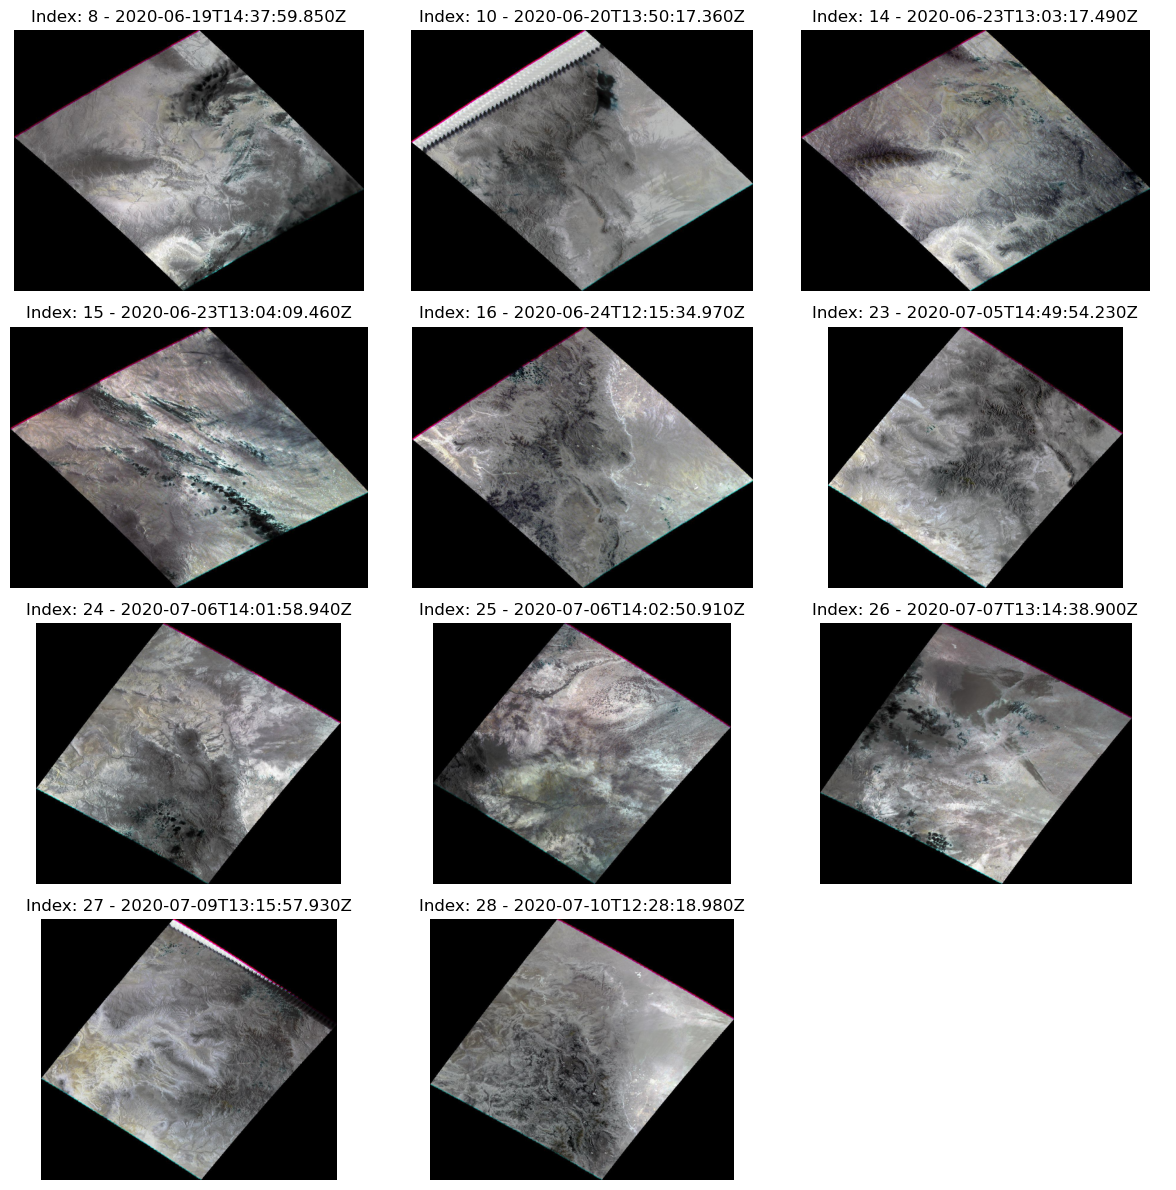

In [13]:
# Look at the browse images to check for quality granules
# Let's do this just for LSTE as we hope the quality days will be the same for both products

short_name = short_names[0] # this is our LST short name identified earlier
gdf = results_rmnp[short_names[1]] # this is the search result dictionary for LST

browse_urls = gdf['browse'].tolist()

cols = 3
rows = math.ceil(len(gdf) / cols)
fig, ax = plt.subplots(rows, cols, figsize=(12,12))
ax = ax.flatten()

for _n, (index, row) in enumerate(gdf.iterrows()):
    try:
        img = io.imread(row['browse'])
        ax[_n].imshow(img)
        ax[_n].set_title(f"Index: {index} - {row['start_datetime']}")
        ax[_n].axis('off')
    except Exception as e:
        print(f"Could not load image at {row['browse']}: {e}")
        ax[_n].axis('off')
        ax[_n].text(0.5, 0.5, 'Image not available', ha='center', va='center')

# Turn off any remaining empty subplots
for i in range(_n + 1, len(ax)):
    ax[i].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.tight_layout()
plt.show()

#### Download or stream granules

Now we have a list of data links including the geolocation information. We can download these data to a local directory. Based on the browse images above, we can select a couple granules which look like they have quality data.

In [14]:
# Select indices which have good data
good_dates = [16]

# Get Https Session using Earthdata Login Info
fs = earthaccess.get_requests_https_session()

# Define the output directory
dest = '/home/jovyan/HYR-SENSE/data/Drought-FireRisk/' 

t0 = time.time() # begin time

# Loop through earch search result data frame, retrieve the data links, and download the files
for short_name, gdf in results_rmnp.items():

    # Get the good data products
    gdf = gdf[gdf.index.isin(good_dates)]
    print(gdf['concept_id'])
    print(len(gdf))

    print(gdf['identifier'])

    print(f'Downloading {short_name}: {len(gdf)} granules')

    # Grab the download URLs
    data_links = [data_link for data_link in gdf['data_link']]

    # Download the data granules    
    for url in data_links:
        print(url)
        granule_id = os.path.basename(url)
        print(f"Granule ID: {granule_id}")

        out_path = os.path.join(dest,f'{short_name}')
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        fp = os.path.join(out_path,f'{granule_id}')
    
        # Download the Granule Asset if it doesn't exist
        if not os.path.isfile(fp):
            with fs.get(url,stream=True) as src:
                with open(fp,'wb') as dst:
                    for chunk in src.iter_content(chunk_size=64*1024*1024):
                        dst.write(chunk)
        else:
            print("*** Already downloaded ***")
            print(" ")
    
        print('Time to complete granule:', time.time() - t0)

print('Total time:', time.time() - t0)

16    G1881780881-LPDAAC_ECS
Name: concept_id, dtype: object
1
16    ECOSTRESS_L2_LSTE_11158_004_20200624T121534_06...
Name: identifier, dtype: object
https://e4ftl01.cr.usgs.gov//ECOB/ECOSTRESS/ECO2LSTE.001/2020.06.24/ECOSTRESS_L2_LSTE_11158_004_20200624T121534_0601_01.h5
Granule ID: ECOSTRESS_L2_LSTE_11158_004_20200624T121534_0601_01.h5
*** Already downloaded ***
 
Time to complete granule: 0.0021207332611083984
16    G1884041615-LPDAAC_ECS
Name: concept_id, dtype: object
1
16    ECOSTRESS_L4_ESI_PT-JPL_11158_004_20200624T121...
Name: identifier, dtype: object
https://e4ftl01.cr.usgs.gov//ECOB/ECOSTRESS/ECO4ESIPTJPL.001/2020.06.24/ECOSTRESS_L4_ESI_PT-JPL_11158_004_20200624T121534_0601_01.h5
Granule ID: ECOSTRESS_L4_ESI_PT-JPL_11158_004_20200624T121534_0601_01.h5
*** Already downloaded ***
 
Time to complete granule: 0.003270387649536133
Total time: 0.003321409225463867


### Download the geolocation information

Because we are working with the V1 data, we also need to pull the geolocation information for these granules.

In [16]:
# Define the geolocation identifier
geo_id = "ECOSTRESS_L1B_GEO_"
short_name = 'ECO1BGEO'

# Select indices which have good data
good_dates = [16]

lst = results_rmnp[short_names[0]]
lst_selected = lst[lst.index.isin(good_dates)]
selected_granules = []
for identifier in lst_selected['identifier']:
    print(identifier)
    # Split the string by underscore
    parts = identifier.split('_')
    # Join the parts from the fourth element to the end to get the desired string
    selected_granules.append('_'.join(parts[3:]))
print(selected_granules)

# Search for the geolocation information and filter based on the 'identifier' that we selected
result = earthaccess.search_data(
    short_name=short_name,
    polygon=coords,
    temporal=date_range,
    count=500, 
)

# Grab the URL for download
# Extract the search results as a data frame
df = pd.json_normalize(result)
links = [granule.data_links()[0] for granule in result]

# Now find the link that matches our selected granules
geo_link = [link for link in links if geo_id+selected_granules[0] in link]
granule_id = os.path.basename(geo_link[0])
print(granule_id)
print(geo_link)

# Download the geolocation data
print(f"Granule ID: {granule_id}")

out_path = os.path.join(dest,f'{short_name}')
if not os.path.exists(out_path):
    os.makedirs(out_path)
fp = os.path.join(out_path,f'{granule_id}')
print(fp)
# Download the Granule Asset if it doesn't exist
if not os.path.isfile(fp):
    with fs.get(geo_link[0],stream=True) as src:
        with open(fp,'wb') as dst:
            for chunk in src.iter_content(chunk_size=64*1024*1024):
                dst.write(chunk)
else:
    print("*** Already downloaded ***")
    print(" ")

ECOSTRESS_L2_LSTE_11158_004_20200624T121534_0601_01.h5
['11158_004_20200624T121534_0601_01.h5']
Granules found: 81
ECOSTRESS_L1B_GEO_11158_004_20200624T121534_0601_01.h5
['https://e4ftl01.cr.usgs.gov//ECOA/ECOSTRESS/ECO1BGEO.001/2020.06.24/ECOSTRESS_L1B_GEO_11158_004_20200624T121534_0601_01.h5']
Granule ID: ECOSTRESS_L1B_GEO_11158_004_20200624T121534_0601_01.h5
/home/jovyan/HYR-SENSE/data/Drought-FireRisk/ECO1BGEO/ECOSTRESS_L1B_GEO_11158_004_20200624T121534_0601_01.h5
